In [1]:
from agent import Agent
from agent_distribution import AgentDistribution
from utils import fixed_point_interpolation_true_distribution, compute_score_bounds
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli, norm
import tqdm
import numpy as np
from scipy.misc import derivative
from utils import compute_continuity_noise
from reparametrized_gradient import expected_gradient_pi_theta, empirical_gradient_pi_theta, empirical_density
from gradient_expected import expected_gradient_pi_s, empirical_gradient_pi_s

In [2]:
agent_dist = AgentDistribution(n=10000, n_types=1)
sigma = compute_continuity_noise(agent_dist)
q = 0.7
f = fixed_point_interpolation_true_distribution(agent_dist, sigma, q, plot=False, savefig=None)

Computing fixed points...


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.49it/s]


Text(0.5, 1.0, 'theta vs. s_theta')

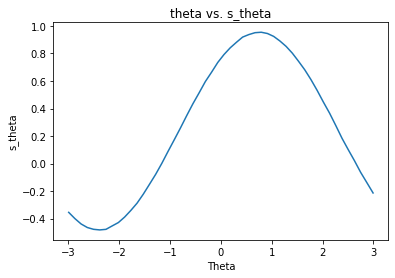

In [3]:
dx = 0.15
thetas = np.linspace(-np.pi + dx, np.pi - dx, 50)
plt.plot(thetas, f(thetas))
plt.xlabel("Theta")
plt.ylabel("s_theta")
plt.title("theta vs. s_theta")

In [4]:
deriv = []
deriv_emp = []
densities = []
densities_est = []
thetas = np.linspace(-np.pi + dx, np.pi - dx, 25)
for theta in thetas:
    s = f(theta)
    r = s
    beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
    density = agent_dist.best_response_pdf(beta, s, sigma, r)
    pi_theta = expected_gradient_pi_theta(agent_dist, theta, sigma , r, f)
    pi_s = expected_gradient_pi_s(agent_dist, theta, sigma, r, f)
    
    hat_pi_theta = empirical_gradient_pi_theta(agent_dist, theta, s, sigma, r)
    hat_pi_s = empirical_gradient_pi_s(agent_dist, beta, s, sigma, r)
    hat_density = empirical_density(agent_dist, beta, s, sigma, r)
    
    densities.append(density)
    densities_est.append(hat_density)
    
    hat_val = -(1/(hat_pi_s + hat_density)) * hat_pi_theta
    val = -(1/(pi_s + density) ) * pi_theta
    deriv.append(val)
    deriv_emp.append(hat_val)
    


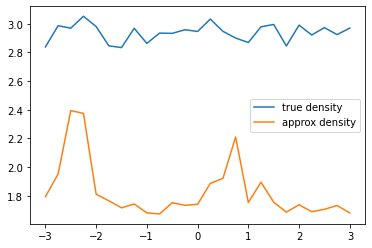

In [5]:
plt.plot(thetas, densities, label="true density")
plt.plot(thetas, densities_est, label="approx density")
plt.legend()

Text(0.5, 1.0, 'ds/dtheta vs. theta')

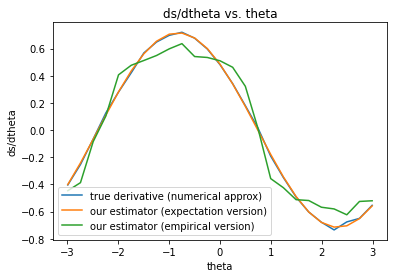

In [6]:
thetas = np.linspace(-np.pi + dx, np.pi - dx, 25)
plt.plot(thetas, np.array([derivative(f, theta, dx) for theta in thetas]), label="true derivative (numerical approx)")
plt.plot(thetas, deriv, label="our estimator (expectation version)")
plt.plot(thetas, [x.item() for x in deriv_emp], label="our estimator (empirical version)")
plt.legend()
plt.xlabel("theta")
plt.ylabel("ds/dtheta")
plt.title("ds/dtheta vs. theta")

In [ ]:
bounds = compute_score_bounds(beta)
thresholds = np.linspace(bounds[0], bounds[1], 50)
plt.plot(thresholds, q_beta(thresholds))
plt.xlabel("s thresholds")
plt.ylabel("q_beta(s)")
plt.title("s vs. q_beta(s)")

In [ ]:
ds = 0.0001
thresholds = np.linspace(bounds[0]+ds, bounds[1]-ds, 50)
dq_beta_ds = np.array([derivative(q_beta, s, ds) for s in thresholds])
plt.plot(thresholds, dq_beta_ds)
plt.title("s vs. dq_beta/ds")
plt.xlabel("s")
plt.ylabel("dq_beta/ds")

In [ ]:
plt.scatter(valid_theta, q_s(valid_theta))
plt.xlabel("Theta")
plt.ylabel("q_s(theta)")
plt.title("Theta vs. q_s(theta)")


In [ ]:
plt.plot(thetas, true_derivatives, label = "true deriv")
plt.plot(thetas, quantile_derivatives, label="implicit function theorem deriv")
plt.legend()

In [ ]:
dtheta = 0.0001
valid_theta_trunc = np.linspace(valid_theta[0] + dtheta, valid_theta[-1]-dtheta, 50)
dq_s_dtheta = np.array([derivative(q_s, theta, dtheta) for theta in valid_theta_trunc])
plt.plot(thresholds, dq_s_dtheta)
plt.title("theta vs. dq_s/dtheta")
plt.xlabel("theta")
plt.ylabel("dq_s/dtheta")

In [ ]:
dtheta = 0.0001
ds = 0.0001


print(true_derivative, quantile_derivative)

In [ ]:
dx = 0.0001
thetas = np.linspace(-np.pi + dx, np.pi - dx, 50)
ds_dtheta = np.array([derivative(f, x, dx) for x in thetas]).reshape(thetas.shape)
plt.plot(thetas, ds_dtheta)
plt.title("beta (theta) vs. ds/dtheta")

In [ ]:
true_derivatives = []
quantile_derivatives = []

for theta in thetas:
    beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
    s_beta = f(theta)
    
    q_beta = agent_dist.quantile_mapping_vary_s(beta, sigma, q)
    q_s, valid_theta = agent_dist.quantile_mapping_vary_beta(s_beta, sigma, q)
    
    true_derivative = derivative(f, theta, dx)
    quantile_derivative = (1/(1 - derivative(q_beta, s_beta, dx))) *derivative(q_s, theta, dx)
    true_derivatives.append(true_derivative)
    quantile_derivatives.append(quantile_derivative)


    
    

In [ ]:
plt.plot(thetas, deriv, label="approx")
plt.plot(thetas, ds_dtheta, label="true")
plt.legend()

In [ ]:
derivs = []
pi_betas = []
for theta in thetas:
    beta = np.array([np.cos(theta), np.sin(theta)]).reshape(2, 1)
    s_beta = f(theta)
    q_s, valid_theta = agent_dist.quantile_mapping_vary_beta(s_beta, sigma, q)
    true_deriv = derivative(q_s, theta, dx)
    dbeta_dtheta = np.array([-np.sin(theta), np.cos(theta)]).reshape(2, 1)
    dcdf_dtheta = np.matmul(expected_gradient_pi_beta(agent_dist, theta, sigma , s_beta, f).T, dbeta_dtheta) 
    density= agent_dist.best_response_pdf(beta, s_beta, sigma, s_beta)
    pi_beta = - dcdf_dtheta/density
    pi_betas.append(pi_beta)
    derivs.append(true_deriv)
    
plt.plot(thetas, pi_betas, label="approx")
plt.plot(thetas, derivs, label="true")
plt.legend()
plt.xlabel("Theta")
plt.ylabel("dq/dtheta")